# Clopper-Pearsonの信頼区間

* 黒木玄
* 2021-12-05

$\newcommand\on{\operatorname}$

関連ノートブック

* [止め方で結果が変わる？](https://nbviewer.org/github/genkuroki/public/blob/main/0025/%E6%AD%A2%E3%82%81%E6%96%B9%E3%81%A7%E7%B5%90%E6%9E%9C%E3%81%8C%E5%A4%89%E3%82%8F%E3%82%8B%EF%BC%9F.ipynb)
* [ベイズハッキング](https://nbviewer.org/github/genkuroki/public/blob/main/0025/Bayes%20hacking.ipynb)

In [1]:
using Distributions
using StatsPlots
using Memoization
using Roots
using StatsFuns: logistic, logit

右辺の部分積分の繰り返しによって以下の公式を示すことができる:

$$
\begin{aligned}
\sum_{j=0}^k \binom{n}{j} \theta^j (1 - \theta)^{n-j} &=
\frac
{\int_\theta^1 t^{(k+1)-1} (1 - t)^{(n-k)-1}\,dt}
{B(k+1, n-k)},
\\
\sum_{j=k}^n \binom{n}{j} \theta^j (1 - \theta)^{n-j} &=
\frac
{\int_0^\theta t^{k-1} (1 - t)^{(n-k+1)-1}\,dt}
{B(k, n-k+1)}.
\end{aligned}
$$

前者の公式の左辺は二項分布 $\on{Binomial}(n, \theta)$ において成功回数が $k$ 以下になる確率であり, 「パラメータの値は $\theta$ 以上である」という帰無仮説の片側検定の $P$ 値とみなされる. 前者の公式の右辺はベイズ統計での対応する場合にimproper共役事前分布 $\on{Beta}(1, 0)$ から得られる事後分布で測ったパラメータの値が $\theta$ 以上になる確率になっている. 後者の公式は前者から導かれる. 

これらの公式は片側検定に関する通常のP値とimproper共役事前分布を用いたベイズ統計の事後分布で測った帰無仮説が成立する確率がぴったり等しいことを意味している.

上の結果を使うと二項分布モデルでの片側検定のP値の2倍で定義した両側検定のP値

$$
\on{pvalue\_dos}(n, k, \theta) =
\min\left\{
1,\;
2\sum_{j=0}^k \binom{n}{j} \theta^j (1 - \theta)^{n-j},\;
2\sum_{j=k}^n \binom{n}{j} \theta^j (1 - \theta)^{n-j}
\right\}
$$

をベータ分布の $\on{cdf}$, $\on{ccdf}$ で表すことができる:

$$
\on{pvalue\_dos}(n, k, \theta) =
\min\left\{
1,\;
2\frac
{\int_\theta^1 t^{(k+1)-1} (1 - t)^{(n-k)-1}\,dt}
{B(k+1, n-k)},\;
2\frac
{\int_0^\theta t^{k-1} (1 - t)^{(n-k+1)-1}\,dt}
{B(k, n-k+1)}
\right\}.
$$

ここで $\on{dos}$ は doubuled one-side の略である.

In [2]:
@memoize function pvalue_dos_naive(n, k, θ)
    bin = Binomial(n, θ)
    min(1, 2sum(pdf(bin, j) for j in 0:k), 2sum(pdf(bin, j) for j in k:n))
end

@memoize function pvalue_dos(n, k, θ)
    k ≤ 0 && return min(1, 2ccdf(Beta(k+1, n-k), θ))
    k ≥ n && return min(1, 2cdf(Beta(k, n-k+1), θ))
    min(1, 2ccdf(Beta(k+1, n-k), θ), 2cdf(Beta(k, n-k+1), θ))
end

pvalue_dos (generic function with 1 method)

In [3]:
# 二項分布モデルにおける両側検定の２つのP値函数が一致することの確認

n = 10
k = 0:n
θ = 0:0.1:1

p1 = pvalue_dos_naive.(n, k, θ')

11×11 Matrix{Float64}:
 1.0  0.697357     0.214748     0.056495     …  2.048e-7     2.0e-10      0.0
 0.0  1.0          0.751619     0.298617        8.3968e-6    1.82e-8      0.0
 0.0  0.527802     1.0          0.765566        0.000155853  7.472e-7     0.0
 0.0  0.140382     0.644401     1.0             0.00172872   1.82432e-5   0.0
 0.0  0.0255904    0.241748     0.700779        0.0127388    0.000293805  0.0
 0.0  0.00326987   0.065587     0.300537     …  0.065587     0.00326987   0.0
 0.0  0.000293805  0.0127388    0.094698        0.241748     0.0255904    0.0
 0.0  1.82432e-5   0.00172872   0.0211842       0.644401     0.140382     0.0
 0.0  7.472e-7     0.000155853  0.00318077      1.0          0.527802     0.0
 0.0  1.82e-8      8.3968e-6    0.000287372     0.751619     1.0          0.0
 0.0  2.0e-10      2.048e-7     1.18098e-5   …  0.214748     0.697357     1.0

In [4]:
p2 = pvalue_dos.(n, k, θ')

11×11 Matrix{Float64}:
 1.0  0.697357     0.214748     0.056495     …  2.048e-7     2.0e-10      0.0
 0.0  1.0          0.751619     0.298617        8.3968e-6    1.82e-8      0.0
 0.0  0.527802     1.0          0.765566        0.000155853  7.472e-7     0.0
 0.0  0.140382     0.644401     1.0             0.00172872   1.82432e-5   0.0
 0.0  0.0255904    0.241748     0.700779        0.0127388    0.000293805  0.0
 0.0  0.00326987   0.065587     0.300537     …  0.065587     0.00326987   0.0
 0.0  0.000293805  0.0127388    0.094698        0.241748     0.0255904    0.0
 0.0  1.82432e-5   0.00172872   0.0211842       0.644401     0.140382     0.0
 0.0  7.472e-7     0.000155853  0.00318077      1.0          0.527802     0.0
 0.0  1.82e-8      8.3968e-6    0.000287372     0.751619     1.0          0.0
 0.0  2.0e-10      2.048e-7     1.18098e-5   …  0.214748     0.697357     1.0

In [5]:
p1 .≈ p2

11×11 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1

__注意:__ 上と同様に右辺の部分積分の繰り返しによって次の公式も示すことができる:

$$
\sum_{m=n}^\infty \binom{m-1}{k-1} \theta^k (1 - \theta)^{m-k} =
\frac
{\int_\theta^1 t^{k-1} (1 - t)^{(n-k)-1}\, dt}
{B(k, n-k)}
\quad (n \ge k \ge 1,\ 0 < \theta \le 1).
$$

左辺の $\binom{m-1}{k-1} \theta^k (1 - \theta)^{m-k}$ は成功確率を意味するパラメータの値が $\theta$ のBernoulli試行をちょうど $k$ 回成功するまで繰り返したときの試行回数がちょうど $m$ 回になる確率なので, 左辺の和はちょうど $k$ 回の成功するまでの試行回数が $n$ 回以上になる確率になっており, 「パラメータの値は $\theta$ 以上である」という帰無仮説の片側検定の $P$ 値とみなされる.  右辺はベイズ統計での対応する場合にimproper事前分布 $\on{Beta}(0, 0)$ から得られる事後分布で測ったパラメータの値が $\theta$ 以上になる確率になっている.

この公式も片側検定に関する通常のP値とimproper共役事前分布を用いたベイズ統計の事後分布で測った帰無仮説が成立する確率がぴったり等しくなっていることを意味している.

`Distributions.jl` における負の二項分布の定義は以下の通り:

$$
\on{pdf}(\on{NegativeBinomial}(r, \theta), k) = \binom{k+r-1}{k} p^r (1 - p)^k \quad (k=0,1,2,\ldots).
$$

ゆえに

$$
\on{pdf}(\on{NegativeBinomial}(k, \theta), m-k) =
\binom{m-1}{m-k} \theta^k (1 - \theta)^{m-k} =
\binom{m-1}{k-1} \theta^k (1 - \theta)^{m-k} \quad (m\ge k).
$$

In [6]:
@memoize pvalue_negbin_naive(n, k, θ) =
    1 - sum(pdf(NegativeBinomial(k, θ), m - k) for m in k:n-1)

@memoize pvalue_negbin(n, k, θ) = ccdf(Beta(k, n-k), θ)

pvalue_negbin (generic function with 1 method)

In [7]:
# 負の二項分布モデルでの片側検定に関する2つのP値函数が一致することの確認

k = 5
n = k+1:15
θ = 0.1:0.1:1

p1 = pvalue_negbin_naive.(n, k, θ')

10×10 Matrix{Float64}:
 0.99999   0.99968   0.99757   0.98976   …  0.67232      0.40951      0.0
 0.999945  0.9984    0.989065  0.95904      0.34464      0.114265     0.0
 0.999823  0.995328  0.971205  0.903744     0.148032     0.0256915    0.0
 0.999568  0.989594  0.942032  0.82633      0.0562816    0.00502435   0.0
 0.999109  0.980419  0.901191  0.733432     0.0195814    0.00089092   0.0
 0.998365  0.967207  0.849732  0.633103  …  0.00636938   0.000146903  0.0
 0.997249  0.94959   0.789695  0.532774     0.00196536   2.28997e-5   0.0
 0.995671  0.927445  0.723655  0.438178     0.000581243  3.41353e-6   0.0
 0.99354   0.900869  0.654314  0.353042     0.000166007  4.90605e-7   0.0
 0.99077   0.87016   0.584201  0.279257     4.60497e-5   6.84042e-8   0.0

In [8]:
p2 = pvalue_negbin.(n, k, θ')

10×10 Matrix{Float64}:
 0.99999   0.99968   0.99757   0.98976   …  0.67232      0.40951      0.0
 0.999945  0.9984    0.989065  0.95904      0.34464      0.114265     0.0
 0.999823  0.995328  0.971205  0.903744     0.148032     0.0256915    0.0
 0.999568  0.989594  0.942032  0.82633      0.0562816    0.00502435   0.0
 0.999109  0.980419  0.901191  0.733432     0.0195814    0.00089092   0.0
 0.998365  0.967207  0.849732  0.633103  …  0.00636938   0.000146903  0.0
 0.997249  0.94959   0.789695  0.532774     0.00196536   2.28997e-5   0.0
 0.995671  0.927445  0.723655  0.438178     0.000581243  3.41353e-6   0.0
 0.99354   0.900869  0.654314  0.353042     0.000166007  4.90604e-7   0.0
 0.99077   0.87016   0.584201  0.279257     4.60497e-5   6.84041e-8   0.0

In [9]:
p1 .≈ p2

10×10 BitMatrix:
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1

上の片側確率の2倍版と異なる二項分布の両側検定のP値を次のように定めることもできる:

$$
\on{pvalue\_exact}(n, k, \theta) =
\sum_{0\le j\le n,\; P(n,j,\theta)\le P(n,k,\theta)} P(n, k, \theta)
$$

ここで $
P(n, k, \theta) = \binom{n}{j} \theta^j (1 - \theta)^{n-j}
$.

In [10]:
x ⪅ y = x < y || x ≈ y

@memoize function pvalue_exact(n, k, θ)
    bin = Binomial(n, θ)
    p0 = pdf(bin, k)
    sum(pdf(bin, j) for j in support(bin) if pdf(bin, j) ⪅ p0)
end

pvalue_exact (generic function with 1 method)

In [11]:
# 別のP値函数が定義されたことの確認

n = 4
k = 0:n
θ = 0:0.1:1

p1 = pvalue_exact.(n, k', θ)
p2 = pvalue_dos.(n, k', θ)
p1 - p2

11×5 Matrix{Float64}:
 -2.22045e-16   0.0           0.0           0.0           0.0
 -2.22045e-16  -0.3439       -0.0523       -0.0037       -0.0001
  0.1808        0.0          -0.1808       -0.0272       -0.0016
 -0.1564       -1.11022e-16  -0.1082       -0.0837       -0.0081
 -0.104         0.0496       -1.11022e-16  -0.0496       -0.0256
 -4.16334e-17  -1.11022e-16   0.0          -1.11022e-16  -4.16334e-17
 -0.0256       -0.0496        0.0           0.0496       -0.104
 -0.0081       -0.0837       -0.1082       -3.33067e-16  -0.1564
 -0.0016       -0.0272       -0.1808       -1.11022e-16   0.1808
 -0.0001       -0.0037       -0.0523       -0.3439       -2.22045e-16
  0.0           0.0           0.0           0.0          -2.22045e-16

これらのＰ値函数 $\on{pvalue\_func} = \on{pvalue\_dos}, \on{pvalue\_exact}$ から信頼度 $1-\alpha$ の信用区間を次のように定義できる:

$$
\on{confidence\_interval}(\on{pvalue\_func}, n, k, \alpha) =
\{\, \theta \in [0, 1] \mid \on{pvalue\_func}(n, k, \theta) \ge \alpha \,\}.
$$

これは $\on{pvalue\_func}(n, k, \theta) = \alpha$ となる $\theta$ を得ることによって数値計算できる.

In [12]:
@memoize function confidence_interval(pvalue_func, n, k, α = 0.05)
    f(t) = pvalue_func(n, k, logistic(t)) - α
    ci = logistic.(find_zeros(f, -10, 10))
    length(ci) < 2 && return 2k ≤ n ? (0.0, first(ci)) : (first(ci), 1.0) 
    (first(ci), last(ci))
end

confidence_interval (generic function with 2 methods)

In [13]:
[(k, confidence_interval(pvalue_dos, 10, k)) for k in 0:10]

11-element Vector{Tuple{Int64, Tuple{Float64, Float64}}}:
 (0, (0.0, 0.30849710781876094))
 (1, (0.0025285785444617856, 0.4450161170281954))
 (2, (0.025210726326833372, 0.5560954623076415))
 (3, (0.0667395111777345, 0.6524528500599973))
 (4, (0.12155225811982719, 0.7376219233930549))
 (5, (0.1870860284473986, 0.8129139715526014))
 (6, (0.26237807660694507, 0.8784477418801727))
 (7, (0.3475471499400027, 0.9332604888222654))
 (8, (0.4439045376923585, 0.9747892736731666))
 (9, (0.5549838829718046, 0.9974714214555381))
 (10, (0.6915028921812391, 1.0))

In [14]:
[(k, confidence_interval(pvalue_exact, 10, k)) for k in 0:10]

11-element Vector{Tuple{Int64, Tuple{Float64, Float64}}}:
 (0, (0.0, 0.2908654309778187))
 (1, (0.005116196891823697, 0.44648866985465113))
 (2, (0.036771437887465085, 0.5535113311975264))
 (3, (0.08726443391415024, 0.6194106589132866))
 (4, (0.15002824080667998, 0.7091345700466994))
 (5, (0.22244110100812914, 0.7775588989918707))
 (6, (0.29086542995330056, 0.84997175919332))
 (7, (0.38058934108671333, 0.9127355660858497))
 (8, (0.44648866880247357, 0.9632285621125348))
 (9, (0.5535113301453488, 0.9948838031081763))
 (10, (0.7091345690221813, 1.0))

特に $\on{pvalue\_func} = \on{pvalue\_dos}$ の場合には上に述べたことから, 以下が成立することがわかる:

$$
\on{confidence\_interval}(\on{pvalue\_dos}, n, k, \alpha) = [\theta_L, \theta_U]
$$

ここで

$$
\frac
{\int_{\theta_U}^1 t^{(k+1)-1} (1 - t)^{(n-k)-1}\,dt}
{B(k+1, n-k)} = \frac{\alpha}{2},
\quad
\frac
{\int_0^{\theta_L} t^{k-1} (1 - t)^{(n-k+1)-1}\,dt}
{B(k, n-k+1)} = \frac{\alpha}{2}.
$$

これらを満たす $\theta_L, \theta_U$ はBeta分布に関する $\on{cquantile}$, $\on{quantile}$ 函数で計算できる.

$\on{confidence\_interval}(\on{pvalue\_dos}, n, k, \alpha)$ を __Clopper-Pearsonの信頼区間__ と呼ぶらしい.

In [15]:
@memoize function confidence_interval_dos(n, k, α = 0.05)
    θ_U = k ≥ n ? 1.0 : cquantile(Beta(k+1, n-k), α/2)
    θ_L = k ≤ 0 ? 0.0 :  quantile(Beta(k, n-k+1), α/2)
    (θ_L, θ_U)
end

confidence_interval_dos (generic function with 2 methods)

In [16]:
# confidence_interval(pvalue_dos, n, k) と confidence_interval(pvalue_dos, n, k) が等しいことの確認

[(k, confidence_interval(pvalue_dos, 10, k) .≈ confidence_interval_dos(10, k)) for k in 0:10]

11-element Vector{Tuple{Int64, Tuple{Bool, Bool}}}:
 (0, (1, 1))
 (1, (1, 1))
 (2, (1, 1))
 (3, (1, 1))
 (4, (1, 1))
 (5, (1, 1))
 (6, (1, 1))
 (7, (1, 1))
 (8, (1, 1))
 (9, (1, 1))
 (10, (1, 1))

In [17]:
# 多重ディスパッチで効率化 (`find_zeros` 函数による計算は効率が悪い)

confidence_interval(::typeof(pvalue_dos), n, k, α = 0.05) = confidence_interval_dos(n, k, α)

confidence_interval (generic function with 4 methods)

In [18]:
methods(confidence_interval)

# 4 methods for generic function "confidence_interval":
[1] confidence_interval(::typeof(pvalue_dos), n, k) in Main at In[17]:3
[2] confidence_interval(::typeof(pvalue_dos), n, k, α) in Main at In[17]:3
[3] confidence_interval(pvalue_func, n, k) in Main at D:\.julia\packages\Memoization\LiJeV\src\Memoization.jl:96
[4] confidence_interval(pvalue_func, n, k, α) in Main at D:\.julia\packages\Memoization\LiJeV\src\Memoization.jl:96

In [19]:
# 多重ディスパッチによる効率化の確認

@which confidence_interval(pvalue_dos, 10, 1)

confidence_interval(::typeof(pvalue_dos), n, k) in Main at In[17]:3

In [20]:
"""有効サポート"""
function effective_support(bin::Binomial; m = 4)
    μ, σ = mean(bin), std(bin)
    a = max(minimum(bin), round(Int, μ - m*σ))
    b = min(maximum(bin), round(Int, μ + m*σ))
    a:b
end

"""二項分布における期待値"""
@memoize function expectation_value(f, n, θ)
    bin = Binomial(n, θ)
    sum(k -> f(k)*pdf(bin, k), effective_support(bin))
end

"""二項分布における確率"""
probability(f, n, θ) = expectation_value(f, n, θ)

"""第一種の過誤が生じる確率をαを動かしてプロット"""
function plot_prob_typeIerror(n, θ)
    p_exact(α) = probability(k -> pvalue_exact(n, k, θ) ⪅ α, n, θ)
    p_dos(α)   = probability(k -> pvalue_dos(n, k, θ) ⪅ α,   n, θ)
    
    α = 0:0.001:1
    tick = 0:0.1:1
    P = plot(; legend=:topleft)
    plot!(α, p_exact; label="pvalue_exact")
    plot!(α, p_dos;   label="pvalue_dos", ls=:dash)
    plot!([0, maximum(α)], [0, maximum(α)]; label="", c=:black, ls=:dot)
    plot!(; xtick=tick, ytick=tick)
    plot!(; xlabel="α", ylabel="probabilty of type I error")

    α = 0:0.0001:0.1
    tick = 0:0.01:0.1
    Q = plot(; legend=:topleft)
    plot!(α, p_exact; label="pvalue_exact")
    plot!(α, p_dos;   label="pvalue_dos", ls=:dash)
    plot!([0, maximum(α)], [0, maximum(α)]; label="", c=:black, ls=:dot)
    plot!(; xtick=tick, ytick=tick)
    plot!(; xlabel="α", ylabel="probabilty of type I error")
    
    plot(P, Q; size=(800, 400), leftmargin=3Plots.mm)
end

plot_prob_typeIerror

αごとに第一種の過誤が実際に起こる確率のグラフが45度線に近いP値函数の方がより正確であると考えられる.

以下を見れば分かるように, `pvalue_exact` の方が `pvalue_dos` よりも正確である.

  3.434522 seconds (7.30 M allocations: 411.980 MiB, 3.05% gc time, 99.25% compilation time)


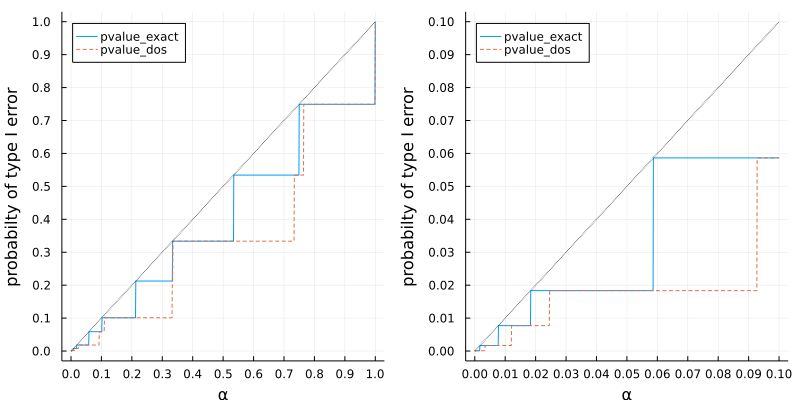

In [21]:
@time plot_prob_typeIerror(10, 0.4)

  0.036781 seconds (183.40 k allocations: 5.983 MiB)


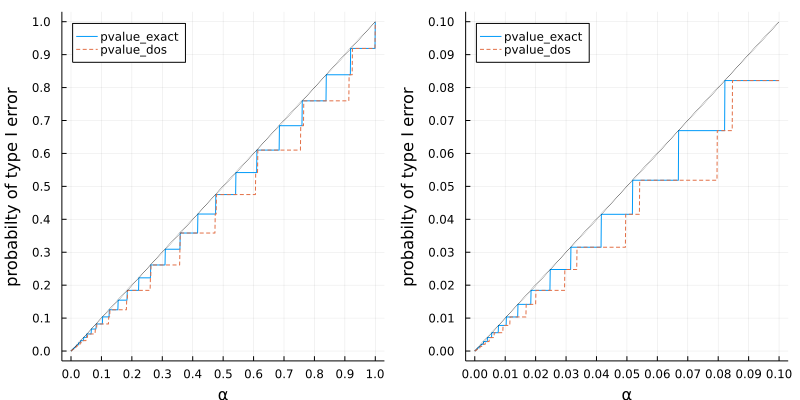

In [22]:
@time plot_prob_typeIerror(100, 0.4)

  0.119466 seconds (503.27 k allocations: 15.739 MiB)


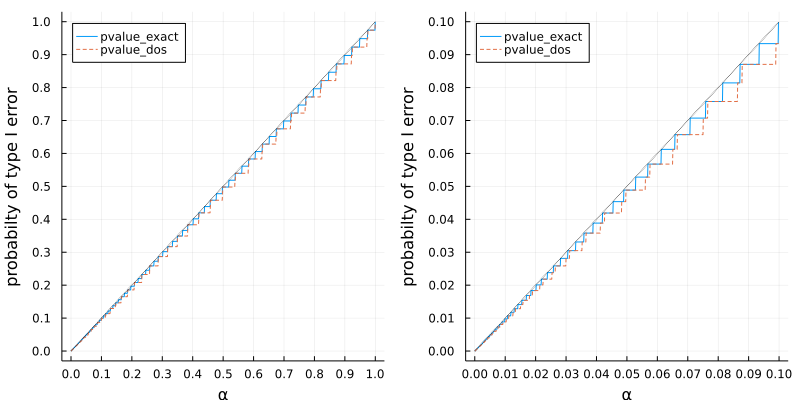

In [23]:
@time plot_prob_typeIerror(1000, 0.4)

In [24]:
"""区間にθが含まれるかどうかを判定する函数"""
contains(interval, θ) = first(interval) ≤ θ ≤ last(interval)

"""信頼区間に真の値が含まれる確率をプロット"""
function plot_coverage_prob(n, α = 0.05, ytick=0:α/5:1)
    c_exact(θ) = probability(k -> contains(confidence_interval(pvalue_exact, n, k, α), θ), n, θ)
    c_dos(θ)   = probability(k -> contains(confidence_interval(pvalue_dos,   n, k, α), θ), n, θ)
    
    θ = 0:0.001:1
    y_exact = similar(θ)
    y_dos   = similar(θ)
    Threads.@threads for i in eachindex(θ)
        y_exact[i] = c_exact(θ[i])
        y_dos[i]   = c_dos(θ[i])
    end
    
    plot(; legend=:bottomright, ylim=(1 - 1.25α, 1 + 0.05α))
    plot!(θ, y_exact; label="pvalue_exact")
    plot!(θ, y_dos;   label="pvalue_dos", ls=:dash)
    hline!([1 - α]; label="", c=:black, ls=:dot)
    plot!(; xtick=0:0.1:1, ytick)
    plot!(; xlabel="θ", ylabel="coverage probability")
    title!("coverage probability for n = $n, α = $α"; titlefontsize=10)
end

plot_coverage_prob

信頼区間に含まれる確率を被覆確率(coverage probability)と呼ぶ.

被覆確率が $1-\alpha$ に近い信頼区間の方がより正確であると考えられる.

以下を見れば分かるように, pvalue_exact の信頼区間の方が pvalue_dos の信頼区間(Clopper-Pearsonの信頼区間)よりも正確である.

  0.536097 seconds (994.22 k allocations: 54.292 MiB, 2.88% gc time, 98.73% compilation time)


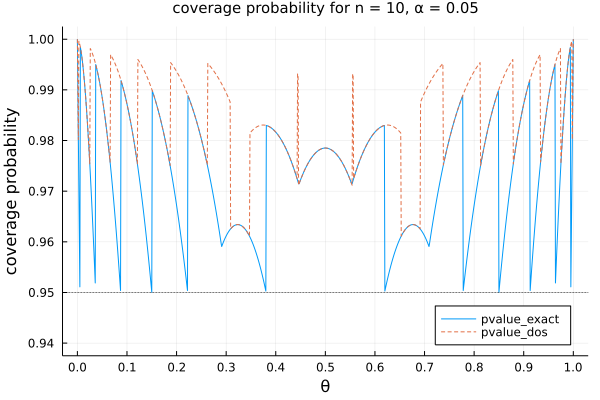

In [25]:
@time plot_coverage_prob(10)

  0.387052 seconds (702.68 k allocations: 49.684 MiB)


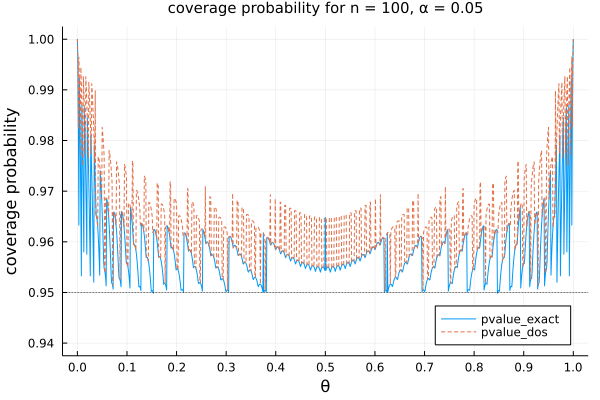

In [26]:
@time plot_coverage_prob(100)

 24.596720 seconds (4.17 M allocations: 254.011 MiB)


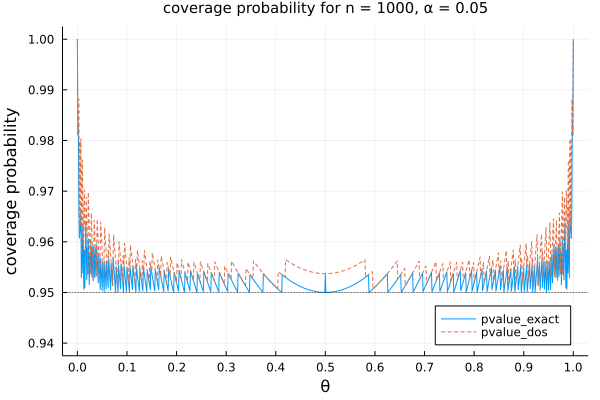

In [27]:
@time plot_coverage_prob(1000)